In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Code Demonstration Notebook

This notebook provides a clear walk-through of the key components used in our study.  
It includes examples of preprocessing, normalization, augmentation, and a simplified  
training and evaluation flow. The goal is to offer transparency into the logic and 
implementation that support the experiments in the paper.

## What this notebook contains

### 1. Sample Data
A small subset of the dataset (text + labels) is loaded to demonstrate the pipeline.
This avoids sharing restricted data while still illustrating the full workflow.

### 2. Preprocessing and Normalization
This section shows:
- Cleaning and text normalisation
- Handling of transliterated Hinglish / Dravidian words
- Religious term normalisation using curated lexicons
- Spelling correction using Levenshtein distance
- Emoji and slang handling  
Each step includes **before/after examples** for clarity.

### 3. Data Augmentation
We demonstrate both sentence-level and word-level augmentation:
- GPT-2 sentence paraphrasing (nlpaug)
- BERT / multilingual BERT word-level contextual augmentation  
We show **multiple augmented outputs** for selected samples.

### 4. Model Setup
A simplified version of the model is provided to clarify:
- Tokenization
- Use of mBERT or MuRIL encoder
- Lightweight classifier head  
The notebook runs **on a small subset** for demonstration purposes only.

### 5. Example Training Run (Small Subset)
To keep runtime minimal, we train for a few steps on a tiny sample.  
This illustrates:
- Loss curves (short)
- Sample predictions
- How the pipeline integrates preprocessing + augmentation + model

### 6. Predictions and Output Examples
We include a table with:
- Original text
- Normalized text
- Augmented variants
- Model output (non-hate / hate)  
These examples match the steps described in the paper.

### 7. Reproducibility Notes
This notebook is meant to **demonstrate logic**, not reproduce the full  
experimental setup. All core components are included in simplified form.

---

### How to Cite This Notebook for Reviewers
This notebook is shared to improve clarity and ensure that the preprocessing,  
augmentation, and classification pipeline is fully visible for validation.

If full code execution is required, a minimal runnable version is included in the 
accompanying GitHub repository.



In [21]:
!pip install nlpaug

In [22]:
import pandas as pd
df= pd.read_csv("https://raw.githubusercontent.com/rajnish8807riday/Sarcasm_multilingual/main/cm_hinglish_f.csv")

In [23]:
import pandas as pd
df1= pd.read_csv("https://raw.githubusercontent.com/umaojha/sarcasm/refs/heads/main/sarcasm_all.csv")
df1.head()

,Unnamed: 0.1,Unnamed: 0,text,label,clean_tweet,English,hindi,sentiment
0,0,0,Triple Talaq par Burbak Kuchh nahi bolega,0,triple talaq par burbak kuchh nahi bolega,burbak kuchh will not say anything on triple t...,तीन तलाक पर कुछ नहीं बोलेंगे बुरबक कुच्छ,No_sarcasm
1,1,1,Batao ye uss site pr se akki sir ke verdict ni...,1,batao ye uss site pr se akki sir ke verdict ni...,tell us from this site that akki sir's verdict...,इस साइट से हमें बताएं कि अक्की सर का फैसला वही...,sarcasm
2,2,2,Hindu baheno par julam bardas nahi hoga @Tripl...,0,hindu baheno par julam bardas nahi hoga hindu ...,"there will be no oppression on hindu sisters, ...","""हिन्दू बहनों पर कोई जुल्म नहीं होगा, हमारी हि...",No_sarcasm
3,3,3,Naa bhai.. aisa nhi hai.. mere handle karne se...,0,naa bhai aisa nhi hai mere handle karne se bhi...,"naa brother, it is not like that, i have nothi...","""ना भाई, ऐसा नहीं है, मेरा राजनीति से कोई लेना...",No_sarcasm
4,4,4,#RememberingRajiv aaj agar musalman auraten tr...,0,rememberingrajiv aaj agar musalman auraten tri...,"remembering rajiv, today if muslim women are f...","''राजीव को याद करते हुए, आज अगर मुस्लिम महिलाए...",No_sarcasm


In [24]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers import TextVectorization # Import directly from tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
# for sentiment analysis
import pandas as pd
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score
import numpy as np
os.environ["WANDB_API_KEY"] = "0" ## to silence warning
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)


Number of replicas: 1


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


###  NO-AUG + NO-FOCAL: LSTM-{mBERT, MuRIL} ======

In [25]:
# ====== NO-AUG + NO-FOCAL: LSTM-{mBERT, MuRIL} ======
import re, random, numpy as np, pandas as pd, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- helpers ----------
def _ensure_numeric_label(df):
    if "label" in df.columns:
        try:
            df["label"] = pd.to_numeric(df["label"])
            return df
        except Exception:
            pass
    if "Label" in df.columns:
        df["label"] = df["Label"].astype(str).str.upper().map({"YES":1,"NO":0})
        return df
    raise ValueError("Need 'label' (0/1) or 'Label' (YES/NO).")

def _pick_text_col(df):
    for c in ["text","clean_tweet","new_reviews","Tweet","tweet","content","sentence","review"]:
        if c in df.columns: return c
    raise ValueError(f"No text column found in {list(df.columns)}")

def stratified_split(df):
    df = _ensure_numeric_label(df.copy())
    text_col = _pick_text_col(df)
    X_temp, X_test, y_temp, y_test = train_test_split(
        df[text_col], df["label"], test_size=0.2, stratify=df["label"], random_state=SEED
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=SEED
    )
    df_train = pd.DataFrame({"text":X_train.values,"label":y_train.values})
    df_val   = pd.DataFrame({"text":X_val.values,  "label":y_val.values})
    df_test  = pd.DataFrame({"text":X_test.values, "label":y_test.values})
    print("Distributions:\n Train:", df_train.label.value_counts().to_dict(),
          "\n Val:  ", df_val.label.value_counts().to_dict(),
          "\n Test: ", df_test.label.value_counts().to_dict())
    return df_train, df_val, df_test

class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df["text"].astype(str).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], max_length=self.max_len, truncation=True,
                       padding="max_length", return_tensors="pt")
        return {"input_ids": enc["input_ids"].squeeze(0),
                "attention_mask": enc["attention_mask"].squeeze(0),
                "label": torch.tensor(self.labels[i], dtype=torch.float)}

class LSTMTransformer(nn.Module):
    def __init__(self, model_name, hidden_dim=128, lstm_layers=1, dropout=0.3):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        h = self.backbone.config.hidden_size
        self.lstm = nn.LSTM(h, hidden_dim, num_layers=lstm_layers, batch_first=True,
                            bidirectional=True, dropout=dropout if lstm_layers>1 else 0.0)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, 1)
    def forward(self, input_ids, attention_mask):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        seq = out.last_hidden_state
        lengths = attention_mask.sum(dim=1).cpu()
        packed = nn.utils.rnn.pack_padded_sequence(seq, lengths, batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        x = torch.cat([h_n[-2], h_n[-1]], dim=1)
        x = self.drop(x)
        return self.fc(x)

def get_tokenizer(model_name):
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token if tok.eos_token is not None else "[PAD]"
        tok.pad_token_id = tok.convert_tokens_to_ids(tok.pad_token)
    return tok

def train_eval(model_name, df_train, df_val, df_test, epochs=6, lr=2e-5, bs=16, max_len=128):
    tok = get_tokenizer(model_name)
    tr_ds = TextDataset(df_train, tok, max_len=max_len)
    va_ds = TextDataset(df_val,   tok, max_len=max_len)
    te_ds = TextDataset(df_test,  tok, max_len=max_len)
    tr = DataLoader(tr_ds, batch_size=bs, shuffle=True)
    va = DataLoader(va_ds, batch_size=2*bs, shuffle=False)
    te = DataLoader(te_ds, batch_size=2*bs, shuffle=False)

    model = LSTMTransformer(model_name).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()  # <-- plain BCE, no class weights, no focal
    opt = optim.AdamW(model.parameters(), lr=lr)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=1, verbose=True)

    best=float("inf"); best_state=None
    for ep in range(1, epochs+1):
        # train
        model.train(); tl=0; n=0
        for b in tr:
            opt.zero_grad()
            logits = model(b["input_ids"].to(DEVICE), b["attention_mask"].to(DEVICE))
            loss = criterion(logits, b["label"].to(DEVICE).float().unsqueeze(1))
            loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step(); tl += loss.item(); n += 1
        tl /= max(1,n)

        # val loss for early-stop/lr
        model.eval(); vl=0; m=0
        with torch.no_grad():
            for b in va:
                logits = model(b["input_ids"].to(DEVICE), b["attention_mask"].to(DEVICE))
                loss = criterion(logits, b["label"].to(DEVICE).float().unsqueeze(1))
                vl += loss.item(); m += 1
        vl /= max(1,m)
        print(f"{model_name} | Epoch {ep}/{epochs}  train {tl:.4f}  val {vl:.4f}")
        sched.step(vl)
        if vl < best - 1e-6:
            best, best_state = vl, {k:v.cpu() for k,v in model.state_dict().items()}
    if best_state: model.load_state_dict(best_state)

    # reports @0.5
    def _report(loader, tag):
        model.eval(); all_y, all_p = [], []
        with torch.no_grad():
            for b in loader:
                logits = model(b["input_ids"].to(DEVICE), b["attention_mask"].to(DEVICE))
                p = torch.sigmoid(logits).squeeze(1).cpu().numpy()
                all_p.extend(p); all_y.extend(b["label"].numpy())
        y_true = np.array(all_y).astype(int)
        y_pred = (np.array(all_p) >= 0.5).astype(int)
        print(f"\n=== {model_name} — {tag} (thr=0.5) ===")
        print(classification_report(y_true, y_pred, digits=4, zero_division=0))
        print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

    _report(va,  "VAL")
    _report(te,  "TEST")
    return model

# -------- run (NO augmentation, NO focal) --------
try:
    df_train, df_val, df_test  # reuse if you already split
except NameError:
    df = _ensure_numeric_label(df)  # your original df with text + label/Label
    if "text" not in df.columns:
        df = df.rename(columns={"clean_tweet":"text","new_reviews":"text","Tweet":"text"})
    df_train, df_val, df_test = stratified_split(df)

# LSTM-mBERT
_ = train_eval("bert-base-multilingual-cased", df_train, df_val, df_test,
               epochs=6, lr=2e-5, bs=16, max_len=128)

# LSTM-MuRIL
_ = train_eval("google/muril-base-cased",      df_train, df_val, df_test,
               epochs=6, lr=2e-5, bs=16, max_len=128)


bert-base-multilingual-cased | Epoch 1/6  train 0.1521  val 0.1399
bert-base-multilingual-cased | Epoch 2/6  train 0.1163  val 0.1495
bert-base-multilingual-cased | Epoch 3/6  train 0.0999  val 0.1739
bert-base-multilingual-cased | Epoch 4/6  train 0.0717  val 0.1469
bert-base-multilingual-cased | Epoch 5/6  train 0.0612  val 0.1492
bert-base-multilingual-cased | Epoch 6/6  train 0.0394  val 0.1829

=== bert-base-multilingual-cased — VAL (thr=0.5) ===
              precision    recall  f1-score   support

           0     0.9861    0.9342    0.9595       380
           1     0.5833    0.8750    0.7000        40

    accuracy                         0.9286       420
   macro avg     0.7847    0.9046    0.8297       420
weighted avg     0.9478    0.9286    0.9347       420

Confusion matrix:
 [[355  25]
 [  5  35]]

=== bert-base-multilingual-cased — TEST (thr=0.5) ===
              precision    recall  f1-score   support

           0     0.9889    0.9399    0.9638       949
           

## sample Augmentation using GPT-2 and BERT-multilingual

In [26]:
import random
import pandas as pd

# --------------------------
# GPT-2 Sentence Augmenter
# --------------------------
try:
    import nlpaug.augmenter.sentence as nas
    AUG_SENT_AVAILABLE = True
except Exception:
    AUG_SENT_AVAILABLE = False
    print("[WARN] nlpaug not installed. Install: pip install -U nlpaug")

def build_gpt2_sentence_augmenter(device="cpu"):
    try:
        return nas.ContextualWordEmbsForSentenceAug(
            model_name='gpt2',
            model_type='gpt',
            device=device
        )
    except Exception:
        try:
            return nas.ContextualWordEmbsForSentenceAug(
                model_path='gpt2',
                device=device
            )
        except Exception as e:
            print("Could not load GPT-2 augmenter:", e)
            return None

# --------------------------
# OPTIONAL: BERT-based aug
# --------------------------
try:
    import nlpaug.augmenter.word as naw
    AUG_BERT_OK = True
except Exception:
    AUG_BERT_OK = False

def build_mbert_sentence_augmenter(device="cpu"):
    if not AUG_BERT_OK:
        print("Word-level BERT augmenter not available.")
        return None

    return naw.ContextualWordEmbsAug(
        model_path="bert-base-multilingual-uncased",
        device=device,
        action="substitute"
    )

# --------------------------
# Preview Function
# --------------------------
def preview_augmentations(df, minority_label=1, k=4, sample_size=1, use_mbert=False):
    df_min = df[df["label"] == minority_label].sample(sample_size, random_state=42)

    if use_mbert:
        print("\nUsing multilingual BERT augmentation.\n")
        aug = build_mbert_sentence_augmenter()
    else:
        print("\nUsing GPT-2 sentence-level augmentation.\n")
        aug = build_gpt2_sentence_augmenter()

    if aug is None:
        print("Augmenter unavailable.")
        return

    for idx, row in df_min.iterrows():
        text = row["text"]
        print("=" * 80)
        print("Original:", text)
        print("-" * 80)

        try:
            outs = aug.augment(text, n=k)
            if isinstance(outs, str):
                outs = [outs]
        except Exception as e:
            print("Augmentation failed:", e)
            continue

        for i, aug_t in enumerate(outs):
            print(f"AUG-{i+1}:", aug_t)
        print()

# --------------------------
# MAIN EXAMPLE
# --------------------------
if __name__ == "__main__":
    # Load any CSV (or replace with your df in memory)
    #df = pd.read_csv("your_dataset.csv")

    # Ensure columns exist
    df = df.rename(columns={"clean_tweet":"text"}) if "clean_tweet" in df.columns else df

    print("Showing GPT-2 sentence-level augmentations:\n")
    preview_augmentations(df, minority_label=1, k=4, sample_size=1, use_mbert=False)

    print("\nShowing multilingual BERT-based augmentations:\n")
    preview_augmentations(df, minority_label=1, k=4, sample_size=1, use_mbert=True)


Showing GPT-2 sentence-level augmentations:


Using GPT-2 sentence-level augmentation.

Original: #ManmohanSingh : Humein shaanti se kaam lena chahiye.  #NawazSharif: Hum bhi shaanti ki lene mein vishwaas karte hain.  #Irony
--------------------------------------------------------------------------------
AUG-1: #ManmohanSingh : Humein shaanti se kaam lena chahiye.  #NawazSharif: Hum bhi shaanti ki lene mein vishwaas karte hain.  #Irony S 2 : " , .
AUG-2: #ManmohanSingh : Humein shaanti se kaam lena chahiye.  #NawazSharif: Hum bhi shaanti ki lene mein vishwaas karte hain.  #Irony # / I .
AUG-3: #ManmohanSingh : Humein shaanti se kaam lena chahiye.  #NawazSharif: Hum bhi shaanti ki lene mein vishwaas karte hain.  #Irony The s ( 0 The _ / of s : 2 4 the / 1 ( - 3 " and I 1 .
AUG-4: #ManmohanSingh : Humein shaanti se kaam lena chahiye.  #NawazSharif: Hum bhi shaanti ki lene mein vishwaas karte hain.  #Irony - 4 " and 2 _ 5 4 / 0 3 2 of a 3 and <|endoftext|> / 1 : , a ( .


Showing multilin

In [27]:
import nlpaug.augmenter.sentence as nas


In [28]:
def build_gpt2_sentence_augmenter(device_aug="cpu", batch_size=32):
    """
    Prefer the user's API: model_name='gpt2', model_type='gpt'.
    If that fails (older nlpaug), fall back to model_path='gpt2'.
    """
    try:
        return nas.ContextualWordEmbsForSentenceAug(
            model_name='gpt2', model_type='gpt', device=device_aug, batch_size=batch_size
        )
    except Exception:
        # Fallback to older/standard signature
        return nas.ContextualWordEmbsForSentenceAug(
            model_path='gpt2', device=device_aug, batch_size=batch_size
        )


## LSTM / BiLSTM / GRU + mBERT encoder | AFTER (sentence-level GPT-2 aug, exact-k=4)

In [29]:
# =========================================================
# LSTM / BiLSTM / GRU + mBERT encoder | AFTER (sentence-level GPT-2 aug, exact-k)
# - Only runs AFTER augmentation (no BEFORE runs)
# - Sentence-level augmentation: GPT-2 paraphrasing via nlpaug (with fallback)
# - Exactly k paraphrases per minority sample (default k=4)
# - Saves loss/acc curves + confusion matrices
# =========================================================

import os, warnings, random, math, numpy as np, pandas as pd
os.environ["TOKENIZERS_PARALLELISM"] = "false"
try:
    from transformers.utils import logging as hf_logging
    hf_logging.set_verbosity_error()
except Exception:
    pass
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# AMP (new/old PyTorch)
try:
    from torch.amp import GradScaler, autocast
except Exception:
    from torch.cuda.amp import GradScaler, autocast

from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# nlpaug (sentence-level GPT-2 paraphrase)
try:
    import nlpaug.augmenter.sentence as nas
    AUG_SENT_AVAILABLE = True
except Exception:
    AUG_SENT_AVAILABLE = False
    print("[WARN] nlpaug sentence augmenter not installed. "
          "Install with: pip install -U nlpaug")

# ------------- Repro -------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
try: torch.set_float32_matmul_precision("high")
except Exception: pass

# ------------- Config -------------
MODEL_NAME       = "bert-base-multilingual-uncased"  # mBERT encoder (DO NOT CHANGE)
MAX_LENGTH       = 96
BATCH_SIZE       = 8
EPOCHS           = 6
FREEZE_BERT      = True
LR_ENCODER       = 2e-5
LR_HEAD          = 1e-3
WEIGHT_DECAY     = 0.01
GRAD_ACCUM       = 2
WARMUP_PCT       = 0.06

# Augmentation controls (sentence-level GPT-2)
MINORITY_LABEL   = 1
K_AUG_PER_ITEM   = 4

ROOT_DIR         = "results"
os.makedirs(ROOT_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE, "| Sentence-level aug: GPT-2")

# ------------- Data helpers -------------
def ensure_text_and_label(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "text" not in df.columns:
        for c in ["clean_tweet","new_reviews","Tweet","tweet","content","sentence","review"]:
            if c in df.columns:
                df = df.rename(columns={c:"text"}); break
    if "text" not in df.columns:
        raise ValueError("Need a text column (e.g., 'text').")
    if "label" not in df.columns:
        if "Label" in df.columns:
            df["label"] = df["Label"].astype(str).str.upper().map({"YES":1,"NO":0})
        else:
            raise ValueError("Need 'label' (0/1) or 'Label' (YES/NO).")
    df["label"] = pd.to_numeric(df["label"])
    df["text"]  = df["text"].astype(str).str.strip()
    df = df.dropna(subset=["text","label"])
    df = df[df["text"].str.len()>0].reset_index(drop=True)
    return df[["text","label"]]

def stratified_split(df, test_size=0.2, val_size=0.1, seed=SEED):
    X_temp, X_test, y_temp, y_test = train_test_split(
        df["text"], df["label"], test_size=test_size, stratify=df["label"], random_state=seed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=seed
    )
    df_tr = pd.DataFrame({"text":X_train.values, "label":y_train.values})
    df_va = pd.DataFrame({"text":X_val.values,   "label":y_val.values})
    df_te = pd.DataFrame({"text":X_test.values,  "label":y_test.values})
    print("Class counts:\n  Train:", df_tr.label.value_counts().to_dict(),
          "\n  Val:  ", df_va.label.value_counts().to_dict(),
          "\n  Test: ", df_te.label.value_counts().to_dict())
    return df_tr, df_va, df_te

# ------------- Sentence-level GPT-2 augmenter -------------
def build_gpt2_sentence_augmenter(device_aug="cpu", batch_size=32):
    """
    Prefer model_name/model_type signature; fallback to model_path for older nlpaug.
    """
    if not AUG_SENT_AVAILABLE:
        return None
    try:
        return nas.ContextualWordEmbsForSentenceAug(
            model_name='gpt2', model_type='gpt', device=device_aug, batch_size=batch_size
        )
    except Exception:
        try:
            return nas.ContextualWordEmbsForSentenceAug(
                model_path='gpt2', device=device_aug, batch_size=batch_size
            )
        except Exception as e:
            print("[AUG-sent] Could not build GPT-2 augmenter:", e)
            return None

def augment_minority_sentence_level(
    df_train: pd.DataFrame,
    text_col: str = "text",
    label_col: str = "label",
    minority_label: int = 1,
    k: int = 4,
    device_aug: str = "cpu",
    seed: int = 42,
    tokenizer_for_trim=None,
    max_length: int = 96
):
    """
    For every minority sample, create EXACTLY k sentence-level GPT-2 paraphrases.
    Returns original + augmented, shuffled.
    """
    random.seed(seed); np.random.seed(seed)
    df = df_train.copy().reset_index(drop=True)
    min_df = df[df[label_col] == minority_label].reset_index(drop=True)
    if len(min_df) == 0:
        print("[AUG-sent] No minority rows; returning original df.")
        return df

    aug = build_gpt2_sentence_augmenter(
        device_aug=("cuda" if torch.cuda.is_available() and device_aug=="cuda" else "cpu"),
        batch_size=32
    )
    if aug is None:
        print("[AUG-sent] Augmenter unavailable; returning original df.")
        return df

    aug_texts = []
    for t in min_df[text_col].tolist():
        try:
            outs = aug.augment(t, n=k)
            if isinstance(outs, str):
                outs = [outs]
            outs = (outs + [t] * k)[:k] if len(outs) < k else outs[:k]
        except Exception:
            outs = [t] * k  # preserve count if generation fails

        # Optional trimming hook (we let Dataset handle truncation anyway)
        if tokenizer_for_trim is not None:
            outs = [s for s in outs]
        aug_texts.extend(outs)

    df_aug = pd.DataFrame({text_col: aug_texts,
                           label_col: [minority_label] * (len(min_df) * k)})

    out = pd.concat([df, df_aug], ignore_index=True)\
            .sample(frac=1.0, random_state=seed).reset_index(drop=True)

    print(f"[AUG-sent:gpt2] minority={minority_label} | originals={len(min_df)} | added={len(min_df)*k} (k={k})")
    print("Final counts:", out[label_col].value_counts().to_dict())
    return out

# ------------- Dataset -------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, max_length: int):
        self.texts = df["text"].tolist()
        self.labels = df["label"].astype(int).tolist()
        self.max_length = max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True, padding="max_length",
            max_length=self.max_length, return_tensors="pt"
        )
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# ------------- Models (LSTM / BiLSTM / GRU) -------------
class BertRNNHead(nn.Module):
    def __init__(self, rnn_type="lstm", hidden_dim=100, bidirectional=False,
                 model_name=MODEL_NAME, freeze_bert=True, dropout=0.3):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name)
        try: self.bert.gradient_checkpointing_enable()
        except Exception: pass
        if freeze_bert:
            for p in self.bert.parameters(): p.requires_grad=False
        emb_dim = self.config.hidden_size  # 768 for BERT-base

        self.rnn_type = rnn_type.lower()
        self.bidirectional = bidirectional

        if self.rnn_type == "gru":
            self.rnn = nn.GRU(input_size=emb_dim, hidden_size=hidden_dim,
                              batch_first=True, bidirectional=bidirectional)
        else:
            self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim,
                               batch_first=True, bidirectional=bidirectional)

        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.drop = nn.Dropout(dropout)
        self.fc   = nn.Linear(out_dim, 1)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq = out.last_hidden_state
        rnn_out, _ = self.rnn(seq)
        h = rnn_out[:, -1, :]
        h = self.drop(h)
        logits = self.fc(h).squeeze(-1)
        return logits

# ------------- Train/Eval utils -------------
def make_loaders(df_train, df_val, df_test, max_length, batch_size):
    train_loader = DataLoader(TextDataset(df_train, max_length), batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
    val_loader   = DataLoader(TextDataset(df_val,   max_length), batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(TextDataset(df_test,  max_length), batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    return train_loader, val_loader, test_loader

def set_optimizers(model):
    enc_params, head_params = [], []
    for n,p in model.named_parameters():
        if p.requires_grad and n.startswith("bert."): enc_params.append(p)
        elif p.requires_grad: head_params.append(p)
    return torch.optim.AdamW([
        {"params": enc_params,  "lr": LR_ENCODER, "weight_decay": WEIGHT_DECAY},
        {"params": head_params, "lr": LR_HEAD,    "weight_decay": 0.0},
    ])

def train_epoch(model, loader, optim, scaler, scheduler):
    model.train(); loss_fn=nn.BCEWithLogitsLoss()
    total_loss,total_acc,n=0,0,0
    for step,batch in enumerate(loader):
        ids=batch["input_ids"].to(DEVICE, non_blocking=True)
        mask=batch["attention_mask"].to(DEVICE, non_blocking=True)
        y=batch["labels"].to(DEVICE, non_blocking=True)
        with autocast(device_type=("cuda" if DEVICE.type=="cuda" else "cpu")):
            logits=model(ids,mask); loss=loss_fn(logits,y)
        scaler.scale(loss).backward()
        if (step+1)%GRAD_ACCUM==0:
            scaler.step(optim); scaler.update(); optim.zero_grad(set_to_none=True)
            if scheduler: scheduler.step()
        preds=(torch.sigmoid(logits)>=0.5).long()
        total_acc+=(preds==y.long()).sum().item(); total_loss+=loss.item()*y.size(0); n+=y.size(0)
    return total_loss/n,total_acc/n

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval(); loss_fn=nn.BCEWithLogitsLoss()
    total_loss,total_acc,n=0,0,0; probs_all,labels_all=[],[]
    for batch in loader:
        ids=batch["input_ids"].to(DEVICE, non_blocking=True)
        mask=batch["attention_mask"].to(DEVICE, non_blocking=True)
        y=batch["labels"].to(DEVICE, non_blocking=True)
        logits=model(ids,mask); loss=loss_fn(logits,y)
        probs=torch.sigmoid(logits); preds=(probs>=0.5).long()
        total_acc+=(preds==y.long()).sum().item(); total_loss+=loss.item()*y.size(0); n+=y.size(0)
        probs_all.append(probs.cpu()); labels_all.append(y.cpu())
    return total_loss/n,total_acc/n,torch.cat(probs_all).numpy(),torch.cat(labels_all).numpy()

def plot_curves(train_hist, val_hist, out_dir, name_prefix, show=False):
    os.makedirs(out_dir, exist_ok=True)
    # Loss
    plt.figure()
    plt.plot([x[0] for x in train_hist], label="train_loss")
    plt.plot([x[0] for x in val_hist], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
    plt.savefig(os.path.join(out_dir, f"{name_prefix}_loss.png"), dpi=220, bbox_inches="tight"); plt.close()
    # Acc
    plt.figure()
    plt.plot([x[1] for x in train_hist], label="train_acc")
    plt.plot([x[1] for x in val_hist], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
    plt.savefig(os.path.join(out_dir, f"{name_prefix}_acc.png"), dpi=220, bbox_inches="tight"); plt.close()

def save_and_show_confusion_matrix(cm, out_png):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(out_png, dpi=240, bbox_inches='tight'); plt.close()

def run_once(model_tag: str, rnn_type: str, bidirectional: bool,
             df_train_run: pd.DataFrame, df_val: pd.DataFrame, df_test: pd.DataFrame,
             subdir: str):
    """Train+eval a single configuration and save outputs under results/model_tag/subdir."""
    out_dir = os.path.join(ROOT_DIR, model_tag, subdir)
    os.makedirs(out_dir, exist_ok=True)

    # Data
    train_loader, val_loader, test_loader = make_loaders(
        df_train_run, df_val, df_test, MAX_LENGTH, BATCH_SIZE
    )

    # Model/opt/sched
    model = BertRNNHead(
        rnn_type=rnn_type, hidden_dim=100, bidirectional=bidirectional,
        model_name=MODEL_NAME, freeze_bert=FREEZE_BERT
    ).to(DEVICE)
    optimizer = set_optimizers(model)
    steps = max(1, (len(train_loader)//GRAD_ACCUM))*EPOCHS
    warmup = int(WARMUP_PCT*steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup, steps)
    scaler = GradScaler(enabled=(DEVICE.type=="cuda"))

    # Train
    best_val_loss=float("inf"); train_hist=[]; val_hist=[]
    for ep in range(1, EPOCHS+1):
        tr_loss,tr_acc = train_epoch(model, train_loader, optimizer, scaler, scheduler)
        va_loss,va_acc,_,_ = eval_epoch(model, val_loader)
        train_hist.append((tr_loss,tr_acc)); val_hist.append((va_loss,va_acc))
        print(f"[{model_tag} | {subdir}] Epoch {ep}: train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")
        if va_loss < best_val_loss:
            best_val_loss = va_loss
            torch.save(model.state_dict(), os.path.join(out_dir, "best_model.pt"))

    # Curves
    plot_curves(train_hist, val_hist, out_dir, "history", show=False)

    # Test (reload best)
    model.load_state_dict(torch.load(os.path.join(out_dir, "best_model.pt"), map_location=DEVICE))
    test_loss,test_acc,probs,labels = eval_epoch(model, test_loader)
    preds = (probs>=0.5).astype(int)
    print(f"[{model_tag} | {subdir}] TEST: loss {test_loss:.4f} acc {test_acc:.4f}")

    # Reports
    rep_txt  = classification_report(labels, preds, digits=4, zero_division=0)
    rep_dict = classification_report(labels, preds, digits=4, zero_division=0, output_dict=True)
    print(rep_txt)
    pd.DataFrame(rep_dict).to_csv(os.path.join(out_dir, "classification_report.csv"))

    cm = confusion_matrix(labels, preds)
    pd.DataFrame(cm, index=[0,1], columns=[0,1]).to_csv(os.path.join(out_dir, "confusion_matrix.csv"))
    save_and_show_confusion_matrix(cm, os.path.join(out_dir, "confusion_matrix.png"))

# ========================= MAIN =========================
if __name__ == "__main__":
    # If you already have df with ['text','label'] in memory, comment the csv line.
    # df = pd.read_csv("your_data.csv")
    df = ensure_text_and_label(df)

    # Split
    df_train, df_val, df_test = stratified_split(df)

    # AFTER dataset only (sentence-level GPT-2 augmentation; exact-k per minority)
    df_train_after = augment_minority_sentence_level(
        df_train,
        text_col="text", label_col="label",
        minority_label=MINORITY_LABEL, k=K_AUG_PER_ITEM,
        device_aug=("cuda" if torch.cuda.is_available() else "cpu"),
        seed=SEED,
        tokenizer_for_trim=tokenizer, max_length=MAX_LENGTH
    )

    # Configs to run (AFTER augmentation only)
    configs = [
        ("LSTM",    "lstm",   False),
        ("BiLSTM",  "lstm",   True),
        ("GRU",     "gru",    False),
    ]

    for tag, rnn_type, bi in configs:
        run_once(
            model_tag=tag, rnn_type=rnn_type, bidirectional=bi,
            df_train_run=df_train_after, df_val=df_val, df_test=df_test,
            subdir=f"after_sent_aug_exact{K_AUG_PER_ITEM}_gpt2"
        )

    print("\nDone. See results/<MODEL>/after_sent_aug_exactK_gpt2/ for CSVs & PNGs.")


Using device: cuda | Sentence-level aug: GPT-2
Class counts:
  Train: {0: 3417, 1: 363} 
  Val:   {0: 380, 1: 40} 
  Test:  {0: 949, 1: 101}
[AUG-sent:gpt2] minority=1 | originals=363 | added=1452 (k=4)
Final counts: {0: 3417, 1: 1815}


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[LSTM | after_sent_aug_exact4_gpt2] Epoch 1: train 0.3093/0.8664 | val 0.3370/0.8143
[LSTM | after_sent_aug_exact4_gpt2] Epoch 2: train 0.1907/0.9281 | val 0.2543/0.9286
[LSTM | after_sent_aug_exact4_gpt2] Epoch 3: train 0.1632/0.9385 | val 0.1575/0.9429
[LSTM | after_sent_aug_exact4_gpt2] Epoch 4: train 0.1220/0.9555 | val 0.1380/0.9381
[LSTM | after_sent_aug_exact4_gpt2] Epoch 5: train 0.1082/0.9597 | val 0.1350/0.9429
[LSTM | after_sent_aug_exact4_gpt2] Epoch 6: train 0.0905/0.9635 | val 0.1245/0.9405
[LSTM | after_sent_aug_exact4_gpt2] TEST: loss 0.1309 acc 0.9448
              precision    recall  f1-score   support

         0.0     0.9785    0.9600    0.9691       949
         1.0     0.6807    0.8020    0.7364       101

    accuracy                         0.9448      1050
   macro avg     0.8296    0.8810    0.8528      1050
weighted avg     0.9499    0.9448    0.9468      1050



/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[BiLSTM | after_sent_aug_exact4_gpt2] Epoch 1: train 0.3196/0.8681 | val 0.1918/0.9214
[BiLSTM | after_sent_aug_exact4_gpt2] Epoch 2: train 0.1830/0.9314 | val 0.1885/0.8976
[BiLSTM | after_sent_aug_exact4_gpt2] Epoch 3: train 0.1833/0.9308 | val 0.1633/0.9405
[BiLSTM | after_sent_aug_exact4_gpt2] Epoch 4: train 0.1300/0.9488 | val 0.1616/0.9333
[BiLSTM | after_sent_aug_exact4_gpt2] Epoch 5: train 0.1227/0.9518 | val 0.1684/0.9405
[BiLSTM | after_sent_aug_exact4_gpt2] Epoch 6: train 0.1221/0.9541 | val 0.1695/0.9405
[BiLSTM | after_sent_aug_exact4_gpt2] TEST: loss 0.1515 acc 0.9390
              precision    recall  f1-score   support

         0.0     0.9784    0.9536    0.9658       949
         1.0     0.6480    0.8020    0.7168       101

    accuracy                         0.9390      1050
   macro avg     0.8132    0.8778    0.8413      1050
weighted avg     0.9466    0.9390    0.9419      1050



/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[GRU | after_sent_aug_exact4_gpt2] Epoch 1: train 0.2720/0.8777 | val 0.1413/0.9357
[GRU | after_sent_aug_exact4_gpt2] Epoch 2: train 0.1045/0.9618 | val 0.1745/0.9238
[GRU | after_sent_aug_exact4_gpt2] Epoch 3: train 0.0878/0.9662 | val 0.1429/0.9429
[GRU | after_sent_aug_exact4_gpt2] Epoch 4: train 0.0685/0.9696 | val 0.1171/0.9381
[GRU | after_sent_aug_exact4_gpt2] Epoch 5: train 0.0590/0.9742 | val 0.1133/0.9381
[GRU | after_sent_aug_exact4_gpt2] Epoch 6: train 0.0519/0.9782 | val 0.1134/0.9452
[GRU | after_sent_aug_exact4_gpt2] TEST: loss 0.1190 acc 0.9590
              precision    recall  f1-score   support

         0.0     0.9819    0.9726    0.9772       949
         1.0     0.7636    0.8317    0.7962       101

    accuracy                         0.9590      1050
   macro avg     0.8728    0.9021    0.8867      1050
weighted avg     0.9609    0.9590    0.9598      1050


Done. See results/<MODEL>/after_sent_aug_exactK_gpt2/ for CSVs & PNGs.


## LSTM / BiLSTM / GRU + mBERT Encoder  
### AFTER Augmentation: Sentence-Level BERT (Multilingual + optional BERT-uncased), exact-k = 4

This script trains three RNN variants (LSTM, BiLSTM, and GRU) on top of a
multilingual BERT encoder. The model is trained **after** applying 
sentence-level augmentation to the minority class.

### Augmentation Overview
This code supports two sentence-level augmentation modes:

1. **Multilingual BERT (mBERT) augmentation**  
   - Word-level contextual substitution  
   - Inserted directly into the pipeline  
   - Enabled by default

2. **BERT-uncased augmentation (commented)**  
   - Similar contextual augmentation using the English BERT-uncased model  
   - Useful for Hinglish and English-dominant text  
   - This augmenter is included but commented out in the script  
   - To activate it, simply uncomment the corresponding lines

Both augmenters generate **exactly k = 4** augmented samples for each 
minority-label example.

### What This Code Does
- Loads the dataset and performs stratified train/val/test split  
- Applies sentence-level augmentation to the minority class  
- Runs three models:  
  - **LSTM + mBERT**  
  - **BiLSTM + mBERT**  
  - **GRU + mBERT**  
- Saves:  
  - Accuracy/loss curves  
  - Classification reports  
  - Confusion matrices  
  - Best model checkpoints  
- Organizes output under the `results/` directory

### Notes
- BERT-uncased augmentation is **disabled ** 
  To enable it, un-comment the line inside the augmentation module.  


Using device: cuda
Class counts:
  Train: {0: 3417, 1: 363} 
  Val:   {0: 380, 1: 40} 
  Test:  {0: 949, 1: 101}
[AUG-exact-k] Label=1 | originals=363 | added=1452 (k=4)
Final counts: {0: 3417, 1: 1815}


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[LSTM | before_aug] Epoch 1: train 0.3034/0.8616 | val 0.1593/0.9214
[LSTM | before_aug] Epoch 2: train 0.1781/0.9161 | val 0.1417/0.9381
[LSTM | before_aug] Epoch 3: train 0.1587/0.9262 | val 0.1262/0.9405
[LSTM | before_aug] Epoch 4: train 0.1499/0.9339 | val 0.1262/0.9476
[LSTM | before_aug] Epoch 5: train 0.1291/0.9452 | val 0.1058/0.9524
[LSTM | before_aug] Epoch 6: train 0.1199/0.9508 | val 0.1859/0.9024
[LSTM | before_aug] Epoch 7: train 0.1297/0.9386 | val 0.1119/0.9571
[LSTM | before_aug] Epoch 8: train 0.1113/0.9524 | val 0.1116/0.9619
[LSTM | before_aug] Epoch 9: train 0.1075/0.9561 | val 0.1153/0.9548
[LSTM | before_aug] Epoch 10: train 0.1000/0.9574 | val 0.1098/0.9619


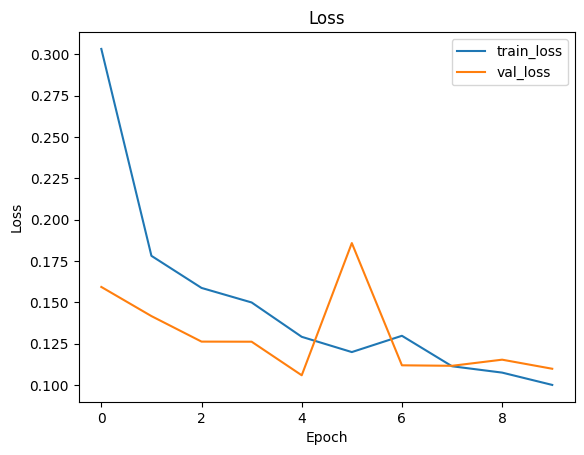

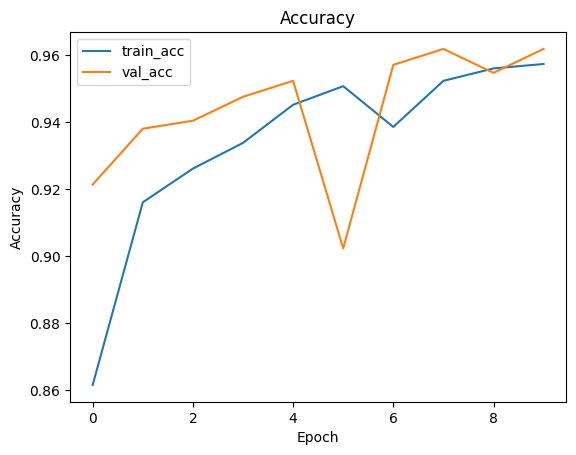

[LSTM | before_aug] TEST: loss 0.1314 acc 0.9371
              precision    recall  f1-score   support

         0.0     0.9732    0.9568    0.9649       949
         1.0     0.6496    0.7525    0.6972       101

    accuracy                         0.9371      1050
   macro avg     0.8114    0.8546    0.8311      1050
weighted avg     0.9421    0.9371    0.9392      1050



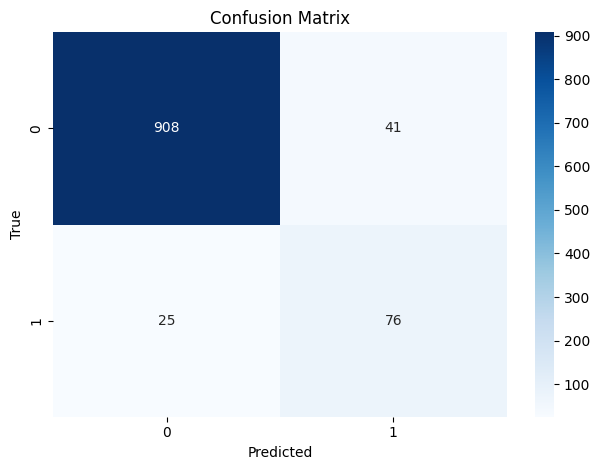

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[LSTM | after_aug_exact4] Epoch 1: train 0.3903/0.8234 | val 0.1789/0.9310
[LSTM | after_aug_exact4] Epoch 2: train 0.2567/0.9050 | val 0.1987/0.9071
[LSTM | after_aug_exact4] Epoch 3: train 0.1919/0.9356 | val 0.1160/0.9405
[LSTM | after_aug_exact4] Epoch 4: train 0.1684/0.9440 | val 0.1424/0.9476
[LSTM | after_aug_exact4] Epoch 5: train 0.1467/0.9515 | val 0.1464/0.9476
[LSTM | after_aug_exact4] Epoch 6: train 0.1618/0.9478 | val 0.1932/0.9429
[LSTM | after_aug_exact4] Epoch 7: train 0.1358/0.9549 | val 0.1399/0.9429
[LSTM | after_aug_exact4] Epoch 8: train 0.1202/0.9570 | val 0.1161/0.9452
[LSTM | after_aug_exact4] Epoch 9: train 0.1164/0.9602 | val 0.1350/0.9476
[LSTM | after_aug_exact4] Epoch 10: train 0.1108/0.9623 | val 0.1221/0.9452


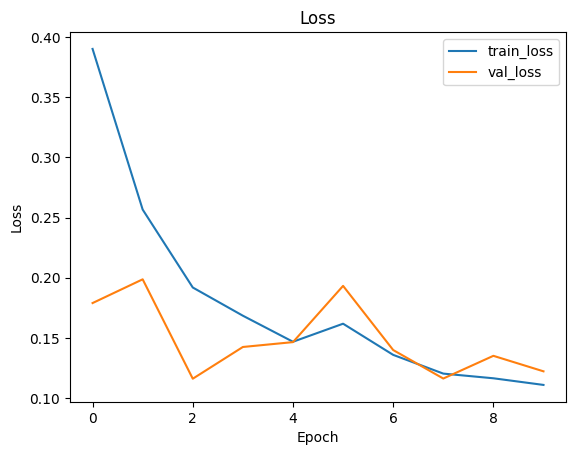

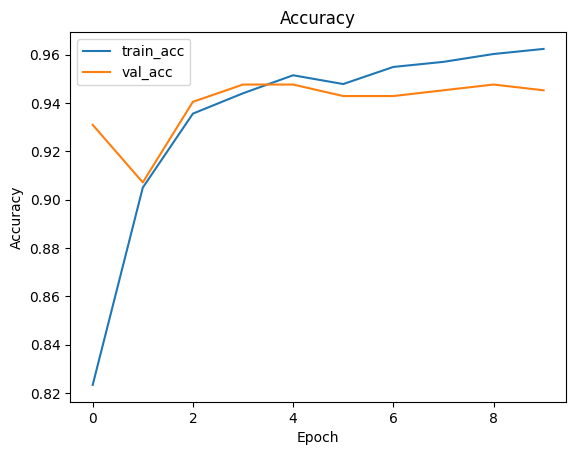

[LSTM | after_aug_exact4] TEST: loss 0.1339 acc 0.9390
              precision    recall  f1-score   support

         0.0     0.9922    0.9399    0.9654       949
         1.0     0.6225    0.9307    0.7460       101

    accuracy                         0.9390      1050
   macro avg     0.8074    0.9353    0.8557      1050
weighted avg     0.9567    0.9390    0.9443      1050



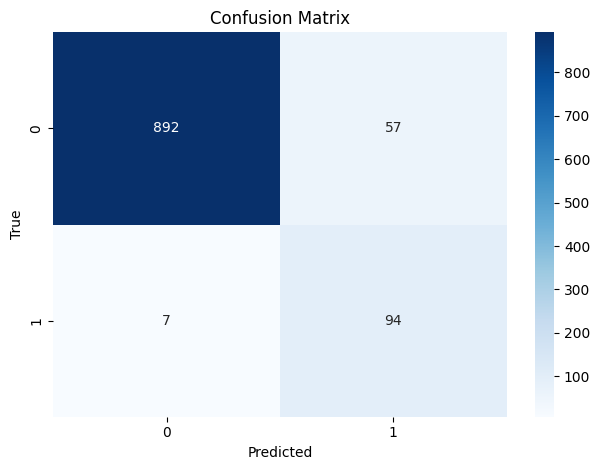

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[BiLSTM | before_aug] Epoch 1: train 0.2890/0.9040 | val 0.2457/0.9095
[BiLSTM | before_aug] Epoch 2: train 0.1790/0.9209 | val 0.1369/0.9190
[BiLSTM | before_aug] Epoch 3: train 0.1755/0.9241 | val 0.1675/0.9286
[BiLSTM | before_aug] Epoch 4: train 0.1448/0.9368 | val 0.1542/0.9286
[BiLSTM | before_aug] Epoch 5: train 0.1386/0.9413 | val 0.1494/0.9381
[BiLSTM | before_aug] Epoch 6: train 0.1275/0.9476 | val 0.1168/0.9500
[BiLSTM | before_aug] Epoch 7: train 0.1259/0.9463 | val 0.1242/0.9524
[BiLSTM | before_aug] Epoch 8: train 0.1075/0.9548 | val 0.1079/0.9595
[BiLSTM | before_aug] Epoch 9: train 0.0992/0.9606 | val 0.0985/0.9595
[BiLSTM | before_aug] Epoch 10: train 0.0941/0.9582 | val 0.0986/0.9571


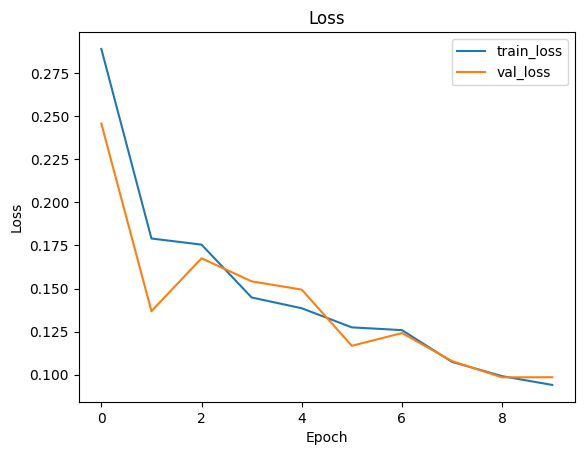

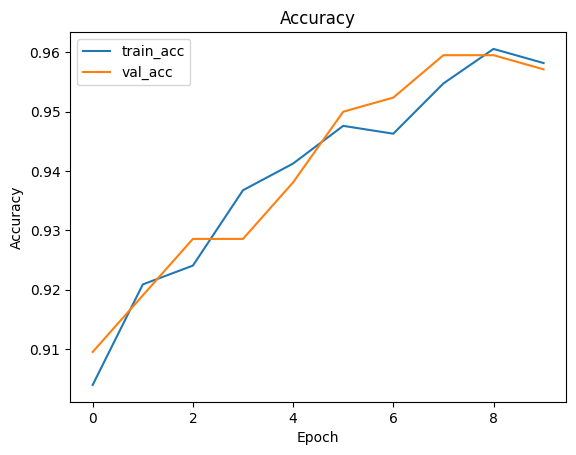

[BiLSTM | before_aug] TEST: loss 0.1147 acc 0.9457
              precision    recall  f1-score   support

         0.0     0.9685    0.9715    0.9700       949
         1.0     0.7245    0.7030    0.7136       101

    accuracy                         0.9457      1050
   macro avg     0.8465    0.8373    0.8418      1050
weighted avg     0.9450    0.9457    0.9453      1050



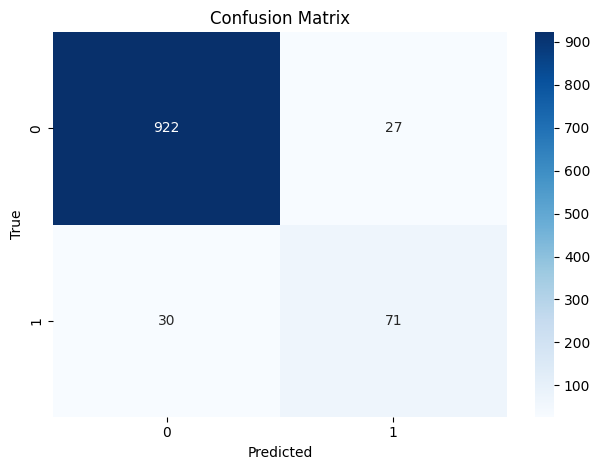

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[BiLSTM | after_aug_exact4] Epoch 1: train 0.3813/0.8150 | val 0.2396/0.8571
[BiLSTM | after_aug_exact4] Epoch 2: train 0.2446/0.9033 | val 0.1588/0.9381
[BiLSTM | after_aug_exact4] Epoch 3: train 0.2107/0.9192 | val 0.1666/0.9429
[BiLSTM | after_aug_exact4] Epoch 4: train 0.1488/0.9472 | val 0.1254/0.9429
[BiLSTM | after_aug_exact4] Epoch 5: train 0.1259/0.9581 | val 0.1486/0.9500
[BiLSTM | after_aug_exact4] Epoch 6: train 0.1094/0.9625 | val 0.1298/0.9500
[BiLSTM | after_aug_exact4] Epoch 7: train 0.1242/0.9566 | val 0.1320/0.9500
[BiLSTM | after_aug_exact4] Epoch 8: train 0.1051/0.9625 | val 0.1343/0.9500
[BiLSTM | after_aug_exact4] Epoch 9: train 0.0948/0.9671 | val 0.1200/0.9500
[BiLSTM | after_aug_exact4] Epoch 10: train 0.0926/0.9675 | val 0.1229/0.9452


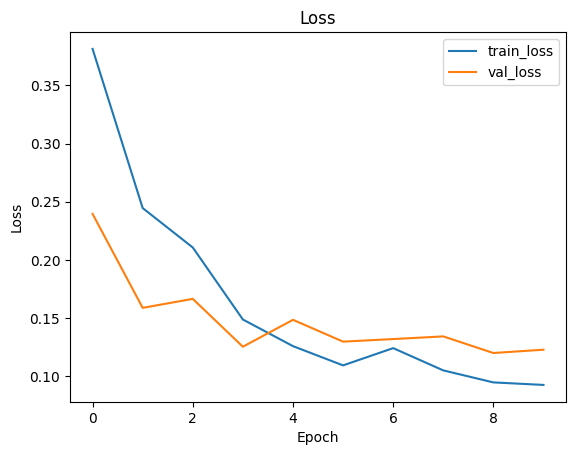

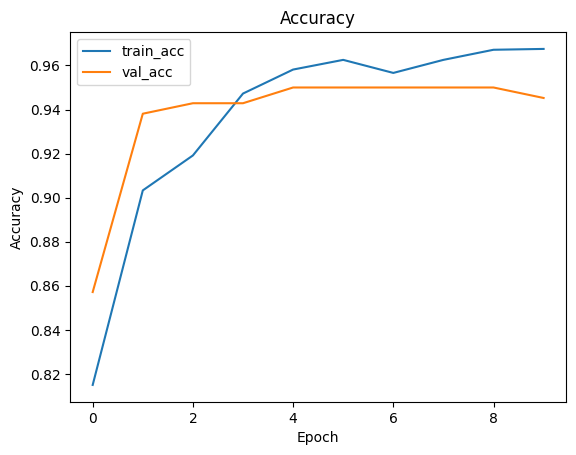

[BiLSTM | after_aug_exact4] TEST: loss 0.1399 acc 0.9495
              precision    recall  f1-score   support

         0.0     0.9934    0.9505    0.9715       949
         1.0     0.6690    0.9406    0.7819       101

    accuracy                         0.9495      1050
   macro avg     0.8312    0.9455    0.8767      1050
weighted avg     0.9622    0.9495    0.9532      1050



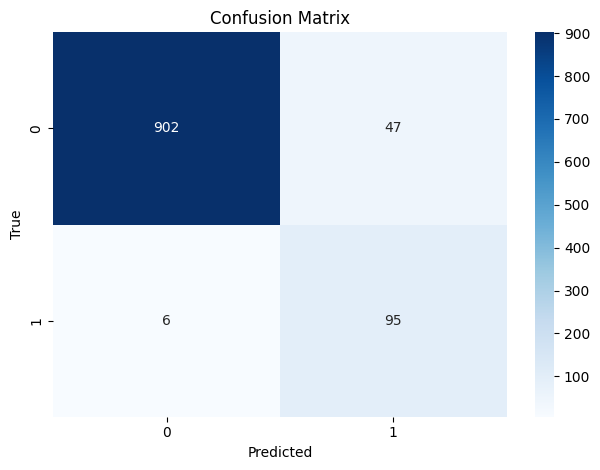

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[GRU | before_aug] Epoch 1: train 0.2770/0.8913 | val 0.1097/0.9500
[GRU | before_aug] Epoch 2: train 0.1151/0.9489 | val 0.0942/0.9452
[GRU | before_aug] Epoch 3: train 0.1002/0.9540 | val 0.0956/0.9500
[GRU | before_aug] Epoch 4: train 0.0935/0.9548 | val 0.0905/0.9571
[GRU | before_aug] Epoch 5: train 0.0811/0.9656 | val 0.0965/0.9524
[GRU | before_aug] Epoch 6: train 0.0800/0.9656 | val 0.0937/0.9548
[GRU | before_aug] Epoch 7: train 0.0693/0.9706 | val 0.1082/0.9476
[GRU | before_aug] Epoch 8: train 0.0700/0.9698 | val 0.0982/0.9500
[GRU | before_aug] Epoch 9: train 0.0628/0.9735 | val 0.1011/0.9524
[GRU | before_aug] Epoch 10: train 0.0534/0.9780 | val 0.1074/0.9500


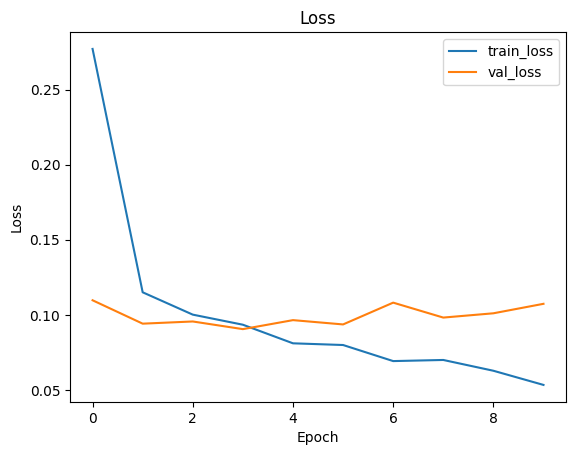

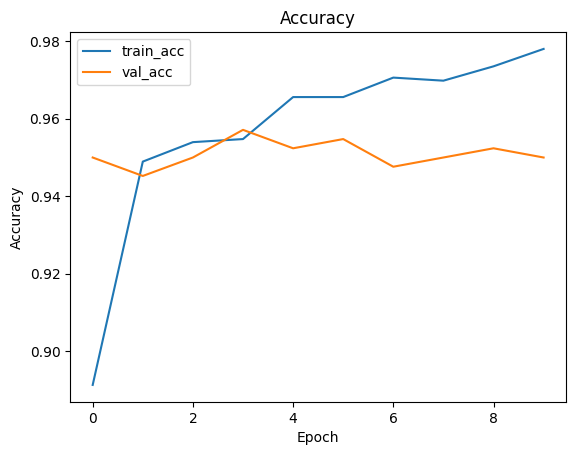

[GRU | before_aug] TEST: loss 0.1056 acc 0.9629
              precision    recall  f1-score   support

         0.0     0.9830    0.9758    0.9794       949
         1.0     0.7870    0.8416    0.8134       101

    accuracy                         0.9629      1050
   macro avg     0.8850    0.9087    0.8964      1050
weighted avg     0.9642    0.9629    0.9634      1050



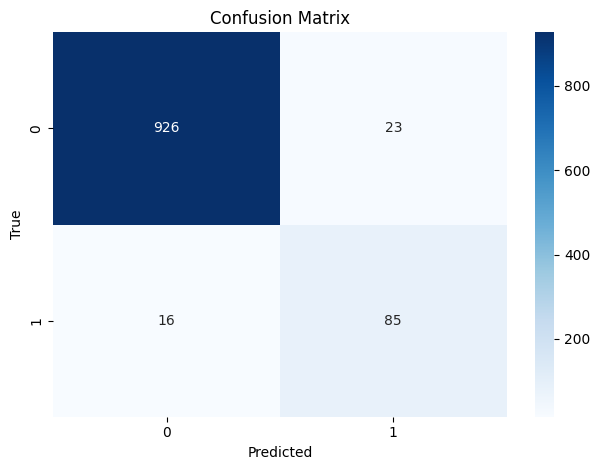

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[GRU | after_aug_exact4] Epoch 1: train 0.3296/0.8477 | val 0.1622/0.9452
[GRU | after_aug_exact4] Epoch 2: train 0.1340/0.9583 | val 0.1263/0.9476
[GRU | after_aug_exact4] Epoch 3: train 0.1135/0.9635 | val 0.1627/0.9452
[GRU | after_aug_exact4] Epoch 4: train 0.0951/0.9669 | val 0.1169/0.9500
[GRU | after_aug_exact4] Epoch 5: train 0.0833/0.9721 | val 0.1231/0.9548
[GRU | after_aug_exact4] Epoch 6: train 0.0693/0.9750 | val 0.1197/0.9571
[GRU | after_aug_exact4] Epoch 7: train 0.0559/0.9813 | val 0.1257/0.9548
[GRU | after_aug_exact4] Epoch 8: train 0.0456/0.9859 | val 0.1412/0.9571
[GRU | after_aug_exact4] Epoch 9: train 0.0323/0.9906 | val 0.1493/0.9571
[GRU | after_aug_exact4] Epoch 10: train 0.0240/0.9929 | val 0.1583/0.9524


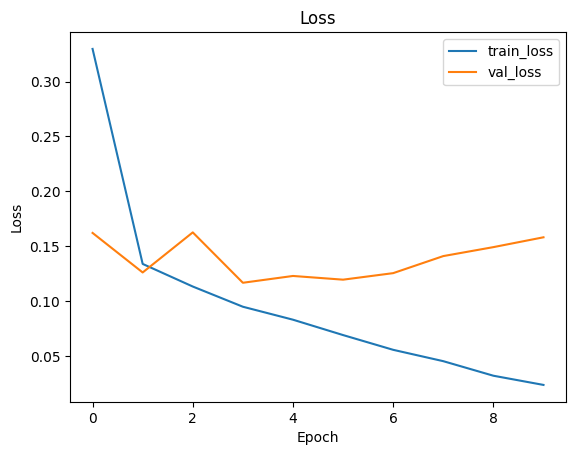

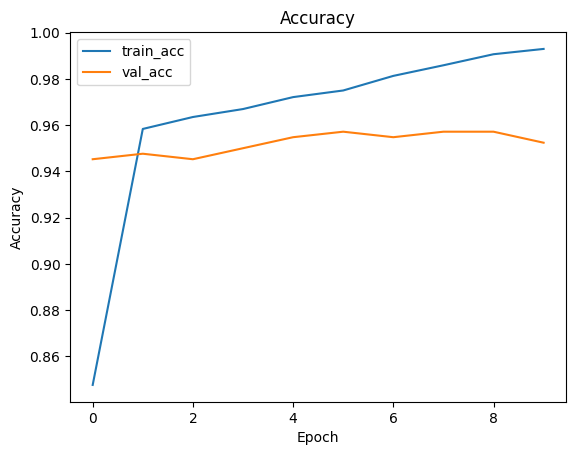

[GRU | after_aug_exact4] TEST: loss 0.1215 acc 0.9667
              precision    recall  f1-score   support

         0.0     0.9914    0.9715    0.9814       949
         1.0     0.7750    0.9208    0.8416       101

    accuracy                         0.9667      1050
   macro avg     0.8832    0.9462    0.9115      1050
weighted avg     0.9706    0.9667    0.9679      1050



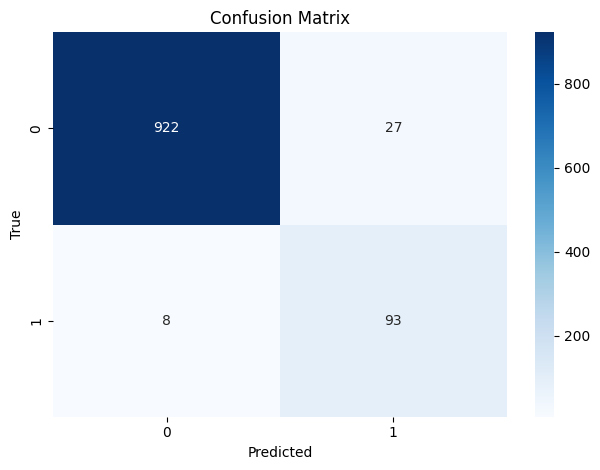


Done. See results/<MODEL>/(before_aug | after_aug_exact4)/ for CSVs & PNGs.


In [30]:
# =========================================================
# LSTM / BiLSTM / GRU + BERT encoder | BEFORE vs AFTER (exact-4 INSERT aug)
# - Exactly 4 INSERT augmentations per minority sample (e.g., sarcasm=1)
# - Shows AND saves loss/acc curves and confusion matrices
# - AMP-compatible; quiet logs
# =========================================================

# ---- Quiet noisy logs ----
import os, warnings, math, random, numpy as np, pandas as pd
os.environ["TOKENIZERS_PARALLELISM"] = "false"
try:
    from transformers.utils import logging as hf_logging
    hf_logging.set_verbosity_error()
except Exception:
    pass
warnings.filterwarnings("ignore", category=FutureWarning)

# ---- Imports ----
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# AMP support (new/old PyTorch)
try:
    from torch.amp import GradScaler, autocast
except Exception:
    from torch.cuda.amp import GradScaler, autocast

from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# nlpaug (INSERT augmentation)
try:
    import nlpaug.augmenter.word as naw
    AUG_AVAILABLE = True
except Exception:
    AUG_AVAILABLE = False
    print("[WARN] nlpaug not installed; AFTER-augmentation run will reuse original train set. "
          "Install with: pip install -U nlpaug")

# ------------------ Repro ------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
try: torch.set_float32_matmul_precision("high")
except Exception: pass

# ------------------ Config ------------------
MODEL_NAME       = "bert-base-multilingual-uncased"  # mBERT encoder (DO NOT CHANGE)

#MODEL_NAME       = "bert-base-uncased"   # encoder (you can switch to mBERT/MuRIL if you want)
MAX_LENGTH       = 96
BATCH_SIZE       = 8
EPOCHS           = 10
FREEZE_BERT      = True
LR_ENCODER       = 2e-5
LR_HEAD          = 1e-3
WEIGHT_DECAY     = 0.01
GRAD_ACCUM       = 2
WARMUP_PCT       = 0.06

# EXACT-K augmentation controls
MINORITY_LABEL   = 1       # <-- set to the sarcasm label id (1 by default)
K_AUG_PER_ITEM   = 4       # EXACTLY 4 variants per minority example
INSERT_TOP_K     = 30

ROOT_DIR         = "results"
os.makedirs(ROOT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ------------------ Data helpers ------------------
def ensure_text_and_label(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "text" not in df.columns:
        for c in ["clean_tweet","new_reviews","Tweet","tweet","content","sentence","review"]:
            if c in df.columns:
                df = df.rename(columns={c:"text"})
                break
    if "text" not in df.columns:
        raise ValueError("Need a text column (e.g., 'text' or 'new_reviews').")
    if "label" not in df.columns:
        if "Label" in df.columns:
            df["label"] = df["Label"].astype(str).str.upper().map({"YES":1,"NO":0})
        else:
            raise ValueError("Need 'label' (0/1) or 'Label' (YES/NO).")
    df["label"] = pd.to_numeric(df["label"])
    df["text"]  = df["text"].astype(str).str.strip()
    df = df.dropna(subset=["text","label"])
    df = df[df["text"].str.len()>0].reset_index(drop=True)
    return df[["text","label"]]

def stratified_split(df, test_size=0.2, val_size=0.1, seed=SEED):
    X_temp, X_test, y_temp, y_test = train_test_split(
        df["text"], df["label"], test_size=test_size, stratify=df["label"], random_state=seed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=seed
    )
    df_tr = pd.DataFrame({"text":X_train.values, "label":y_train.values})
    df_va = pd.DataFrame({"text":X_val.values,   "label":y_val.values})
    df_te = pd.DataFrame({"text":X_test.values,  "label":y_test.values})
    print("Class counts:\n  Train:", df_tr.label.value_counts().to_dict(),
          "\n  Val:  ", df_va.label.value_counts().to_dict(),
          "\n  Test: ", df_te.label.value_counts().to_dict())
    return df_tr, df_va, df_te

# ------------------ Augmentation: INSERT (exact 4 per minority item) ------------------
def build_insert_augmenter(top_k=INSERT_TOP_K, device_aug="cpu"):
    if not AUG_AVAILABLE:
        return None
    return naw.ContextualWordEmbsAug(
        model_path=MODEL_NAME,
        action="insert",
        aug_min=1, aug_max=1,
        top_k=top_k,
        device=device_aug,
        batch_size=32
    )

def augment_minority_exact_k_insert(
    df_train: pd.DataFrame,
    text_col: str = "text",
    label_col: str = "label",
    minority_label: int = MINORITY_LABEL,
    k: int = K_AUG_PER_ITEM,
    top_k: int = INSERT_TOP_K,
    device_aug: str = "cpu"
):
    """
    EXACT k INSERT augmentations per minority sample.
    Returns original + augmented (shuffled).
    """
    if not AUG_AVAILABLE:
        print("[AUG-exact-k] nlpaug not available. Returning original df.")
        return df_train.copy().reset_index(drop=True)

    df = df_train.copy().reset_index(drop=True)
    min_df = df[df[label_col] == minority_label].reset_index(drop=True)
    m = len(min_df)
    if m == 0:
        print("[AUG-exact-k] No minority rows found; returning original df.")
        return df

    aug = build_insert_augmenter(top_k=top_k, device_aug=device_aug)

    aug_texts = []
    for t in min_df[text_col].tolist():
        outs = aug.augment(t, n=k)
        if isinstance(outs, str):
            outs = [outs]
        aug_texts.extend(outs[:k])  # enforce exactly k

    df_aug = pd.DataFrame({text_col: aug_texts,
                           label_col: [minority_label] * (m * k)})
    out = pd.concat([df, df_aug], ignore_index=True).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    print(f"[AUG-exact-k] Label={minority_label} | originals={m} | added={m*k} (k={k})")
    print("Final counts:", out[label_col].value_counts().to_dict())
    return out

# ------------------ Dataset ------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, max_length: int):
        self.texts = df["text"].tolist()
        self.labels = df["label"].astype(int).tolist()
        self.max_length = max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True, padding="max_length",
            max_length=self.max_length, return_tensors="pt"
        )
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# ------------------ Models (LSTM / BiLSTM / GRU) ------------------
class BertRNNHead(nn.Module):
    def __init__(self, rnn_type="lstm", hidden_dim=100, bidirectional=False,
                 model_name=MODEL_NAME, freeze_bert=True, dropout=0.3):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name)
        try: self.bert.gradient_checkpointing_enable()
        except Exception: pass
        if freeze_bert:
            for p in self.bert.parameters(): p.requires_grad=False
        emb_dim = self.config.hidden_size  # e.g., 768

        self.rnn_type = rnn_type.lower()
        self.bidirectional = bidirectional

        if self.rnn_type == "gru":
            self.rnn = nn.GRU(input_size=emb_dim, hidden_size=hidden_dim,
                              batch_first=True, bidirectional=bidirectional)
        else:
            self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim,
                               batch_first=True, bidirectional=bidirectional)

        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.drop = nn.Dropout(dropout)
        self.fc   = nn.Linear(out_dim, 1)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq = out.last_hidden_state           # [B, L, H]
        rnn_out, _ = self.rnn(seq)            # [B, L, out_dim]
        h = rnn_out[:, -1, :]                 # last timestep
        h = self.drop(h)
        logits = self.fc(h).squeeze(-1)       # [B]
        return logits

# ------------------ Training/Eval utils ------------------
def make_loaders(df_train, df_val, df_test, max_length, batch_size):
    train_loader = DataLoader(TextDataset(df_train, max_length), batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
    val_loader   = DataLoader(TextDataset(df_val,   max_length), batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(TextDataset(df_test,  max_length), batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    return train_loader, val_loader, test_loader

def set_optimizers(model):
    enc_params, head_params = [], []
    for n,p in model.named_parameters():
        if p.requires_grad and n.startswith("bert."): enc_params.append(p)
        elif p.requires_grad: head_params.append(p)
    return torch.optim.AdamW([
        {"params": enc_params,  "lr": LR_ENCODER, "weight_decay": WEIGHT_DECAY},
        {"params": head_params, "lr": LR_HEAD,    "weight_decay": 0.0},
    ])

def train_epoch(model, loader, optim, scaler, scheduler):
    model.train(); loss_fn=nn.BCEWithLogitsLoss()
    total_loss,total_acc,n=0,0,0
    for step,batch in enumerate(loader):
        ids=batch["input_ids"].to(DEVICE, non_blocking=True)
        mask=batch["attention_mask"].to(DEVICE, non_blocking=True)
        y=batch["labels"].to(DEVICE, non_blocking=True)
        with autocast(device_type=("cuda" if DEVICE.type=="cuda" else "cpu")):
            logits=model(ids,mask); loss=loss_fn(logits,y)
        scaler.scale(loss).backward()
        if (step+1)%GRAD_ACCUM==0:
            scaler.step(optim); scaler.update(); optim.zero_grad(set_to_none=True)
            if scheduler: scheduler.step()
        preds=(torch.sigmoid(logits)>=0.5).long()
        total_acc+=(preds==y.long()).sum().item(); total_loss+=loss.item()*y.size(0); n+=y.size(0)
    return total_loss/n,total_acc/n

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval(); loss_fn=nn.BCEWithLogitsLoss()
    total_loss,total_acc,n=0,0,0; probs_all,labels_all=[],[]
    for batch in loader:
        ids=batch["input_ids"].to(DEVICE, non_blocking=True)
        mask=batch["attention_mask"].to(DEVICE, non_blocking=True)
        y=batch["labels"].to(DEVICE, non_blocking=True)
        logits=model(ids,mask); loss=loss_fn(logits,y)
        probs=torch.sigmoid(logits); preds=(probs>=0.5).long()
        total_acc+=(preds==y.long()).sum().item(); total_loss+=loss.item()*y.size(0); n+=y.size(0)
        probs_all.append(probs.cpu()); labels_all.append(y.cpu())
    return total_loss/n,total_acc/n,torch.cat(probs_all).numpy(),torch.cat(labels_all).numpy()

def plot_curves(train_hist, val_hist, out_dir, name_prefix, show=True):
    os.makedirs(out_dir, exist_ok=True)
    # Loss
    plt.figure()
    plt.plot([x[0] for x in train_hist], label="train_loss")
    plt.plot([x[0] for x in val_hist], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
    path = os.path.join(out_dir, f"{name_prefix}_loss.png")
    plt.savefig(path, dpi=220, bbox_inches="tight")
    if show: plt.show()
    else: plt.close()
    # Acc
    plt.figure()
    plt.plot([x[1] for x in train_hist], label="train_acc")
    plt.plot([x[1] for x in val_hist], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
    path = os.path.join(out_dir, f"{name_prefix}_acc.png")
    plt.savefig(path, dpi=220, bbox_inches="tight")
    if show: plt.show()
    else: plt.close()

def save_and_show_confusion_matrix(cm, out_png, show=True):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(out_png, dpi=240, bbox_inches='tight')
    if show: plt.show()
    else: plt.close()

def run_once(model_tag: str, rnn_type: str, bidirectional: bool,
             df_train_run: pd.DataFrame, df_val: pd.DataFrame, df_test: pd.DataFrame,
             subdir: str):
    """Train+eval a single configuration and save outputs under results/model_tag/subdir."""
    out_dir = os.path.join(ROOT_DIR, model_tag, subdir)
    os.makedirs(out_dir, exist_ok=True)

    # Data
    train_loader, val_loader, test_loader = make_loaders(
        df_train_run, df_val, df_test, MAX_LENGTH, BATCH_SIZE
    )

    # Model/opt/sched
    model = BertRNNHead(
        rnn_type=rnn_type, hidden_dim=100, bidirectional=bidirectional,
        model_name=MODEL_NAME, freeze_bert=FREEZE_BERT
    ).to(DEVICE)
    optimizer = set_optimizers(model)
    steps = max(1, (len(train_loader)//GRAD_ACCUM))*EPOCHS
    warmup = int(WARMUP_PCT*steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup, steps)
    scaler = GradScaler(enabled=(DEVICE.type=="cuda"))

    # Train
    best_val_loss=float("inf"); train_hist=[]; val_hist=[]
    for ep in range(1, EPOCHS+1):
        tr_loss,tr_acc = train_epoch(model, train_loader, optimizer, scaler, scheduler)
        va_loss,va_acc,_,_ = eval_epoch(model, val_loader)
        train_hist.append((tr_loss,tr_acc)); val_hist.append((va_loss,va_acc))
        print(f"[{model_tag} | {subdir}] Epoch {ep}: train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")
        if va_loss < best_val_loss:
            best_val_loss = va_loss
            torch.save(model.state_dict(), os.path.join(out_dir, "best_model.pt"))

    # Curves: save + show
    plot_curves(train_hist, val_hist, out_dir, "history", show=True)

    # Test (reload best)
    model.load_state_dict(torch.load(os.path.join(out_dir, "best_model.pt"), map_location=DEVICE))
    test_loss,test_acc,probs,labels = eval_epoch(model, test_loader)
    preds = (probs>=0.5).astype(int)
    print(f"[{model_tag} | {subdir}] TEST: loss {test_loss:.4f} acc {test_acc:.4f}")

    # Reports
    rep_txt  = classification_report(labels, preds, digits=4, zero_division=0)
    rep_dict = classification_report(labels, preds, digits=4, zero_division=0, output_dict=True)
    print(rep_txt)
    pd.DataFrame(rep_dict).to_csv(os.path.join(out_dir, "classification_report.csv"))

    cm = confusion_matrix(labels, preds)
    pd.DataFrame(cm, index=[0,1], columns=[0,1]).to_csv(os.path.join(out_dir, "confusion_matrix.csv"))
    # Confusion matrix: save + show
    save_and_show_confusion_matrix(cm, os.path.join(out_dir, "confusion_matrix.png"), show=True)

    # TP/FP/FN/TN examples (handy for explainability inspection later)
    df_te = df_test.reset_index(drop=True).copy()
    df_te["prob"]=probs; df_te["pred"]=preds; df_te["true"]=labels.astype(int)
    df_te[(df_te.true==1)&(df_te.pred==1)].to_csv(os.path.join(out_dir,"TP_examples.csv"), index=False)
    df_te[(df_te.true==0)&(df_te.pred==1)].to_csv(os.path.join(out_dir,"FP_examples.csv"), index=False)
    df_te[(df_te.true==1)&(df_te.pred==0)].to_csv(os.path.join(out_dir,"FN_examples.csv"), index=False)
    df_te[(df_te.true==0)&(df_te.pred==0)].to_csv(os.path.join(out_dir,"TN_examples.csv"), index=False)

# ========================= MAIN =========================
if __name__ == "__main__":
    # --------- Load your data ----------
    # If you already have `df` with ['text','label'] in memory, comment the next 2 lines.
    # df = pd.read_csv("your_data.csv")
    df = ensure_text_and_label(df)

    # Split to train/val/test
    df_train, df_val, df_test = stratified_split(df)

    # BEFORE and AFTER datasets
    df_train_before = df_train.copy()
    df_train_after  = augment_minority_exact_k_insert(
        df_train, text_col="text", label_col="label",
        minority_label=MINORITY_LABEL, k=K_AUG_PER_ITEM,
        top_k=INSERT_TOP_K, device_aug="cpu"
    )

    # ---------- Configs ----------
    configs = [
        # tag,      rnn_type, bidirectional
        ("LSTM",    "lstm",   False),   # LSTM
        ("BiLSTM",  "lstm",   True),    # BiLSTM
        ("GRU",     "gru",    False),   # GRU
    ]

    # ---------- Run each model before and after augmentation ----------
    for tag, rnn_type, bi in configs:
        # BEFORE augmentation
        run_once(
            model_tag=tag, rnn_type=rnn_type, bidirectional=bi,
            df_train_run=df_train_before, df_val=df_val, df_test=df_test,
            subdir="before_aug"
        )
        # AFTER augmentation (exact-4 per minority)
        run_once(
            model_tag=tag, rnn_type=rnn_type, bidirectional=bi,
            df_train_run=df_train_after, df_val=df_val, df_test=df_test,
            subdir="after_aug_exact4"
        )

    print("\nDone. See results/<MODEL>/(before_aug | after_aug_exact4)/ for CSVs & PNGs.")
